### RF
- https://github.com/luanshiyinyang/DataMiningProject/tree/Bearing
- **注意：同一列的数据不一定是同一个时间点的采样数据，即不要把每一列当作一个特征**

In [1]:
import numpy as np
import math
import lightgbm as lgb
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import seaborn as sns
import pywt

from sampen import sampen2
from pyentrp import entropy

from scipy.fftpack import fft, fftfreq, fftn
from scipy.stats import pearsonr
from scipy.io import loadmat
from sklearn.feature_selection import f_classif, chi2, SelectPercentile, SelectFromModel
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
train_path = r"D:\MyWork\Compere\datas\故障\bearing\train.csv"
test_path = r"D:\MyWork\Compere\datas\故障\bearing\test_data.csv"

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

y_train = pd.DataFrame()
y_train['label'] = df_train['label']
df_train.drop(columns='label', inplace=True)

df_train.shape, df_test.shape

((792, 6001), (528, 6001))

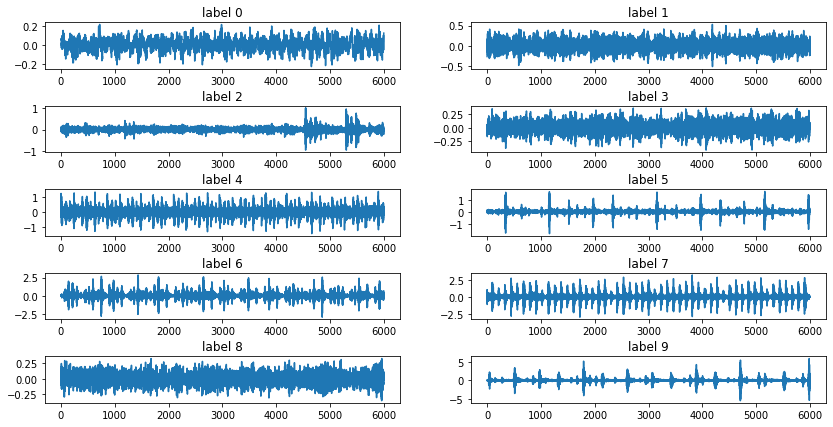

In [3]:
fig,ax = plt.subplots(5,2,figsize=(14, 7))
for i, axi in enumerate(ax.flat):
    temp = df_train[y_train['label'] == i]
    axi.plot(temp.iloc[0]['1':].values)
    axi.set_title('label %s' %i)
# plt.subplots_adjust()
fig.subplots_adjust(hspace=0.8)
# plt.savefig('label pic.png', dpi=400)
plt.show()

<AxesSubplot:xlabel='label', ylabel='count'>

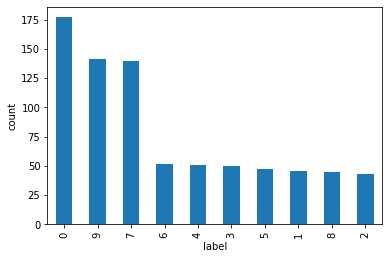

In [4]:
y_train['label'].value_counts().plot(kind='bar', xlabel='label', ylabel='count')

In [9]:
def get_features(df, is_fft=False):
    if is_fft:
        index = 0
    else:
        index = 1
        
    mean_list = []
    std_list = []
    var_list = []
    min_list = []
    max_list = []
    median_list = []
    skew_list = []
    kuri_list = []
    sum_list = []
    abs_sum_list = []
    sum_abs_list = []
    abs_max_list = []
    abs_min_list = []
    per_95_list = [] # 95分位
    per_5_list = []  # 5分位
    per_25_list = [] 
    per_75_list = []  
    jueduijunzhi_list = [] # 绝对均值
    rms_list = []  # 均方根值
    fanggenfuzhi_list = []  # 方根幅值
    waixiedu_list = []  # 歪斜度
    fengzhi_list = []  # 峰值
    fengzhiyinzi_list = []  # 峰值因子
    fengzhizhibiao_list = []  # 峰值指标
    qiaoduzhibiao_list = []  # 峭度指标
    boxingzhibiao_list = []  # 波形指标
    maichongyinzi_list = []  # 脉冲因子
    maichongzhibiao_list = []  # 脉冲指标
    yuduyinzi_list = []  # 裕度因子
    yuduzhibiao_list = [] # 裕度指标
    x = pd.DataFrame()
    for i in range(len(df)):
        this_sample = df.iloc[i].values
        mean_list.append(np.mean(df.iloc[i][index:].values))
        std_list.append(np.std(df.iloc[i][index:].values))
        var_list.append(np.var(df.iloc[i][index:].values))
        min_list.append(np.min(df.iloc[i][index:].values))
        max_list.append(np.max(df.iloc[i][index:].values))
        median_list.append(np.median(df.iloc[i][index:].values))
        skew_list.append(stats.skew(df.iloc[i][index:].values))
        kuri_list.append(stats.kurtosis(df.iloc[i][index:].values))
        sum_list.append(np.sum(df.iloc[i][index:].values))
        abs_sum_list.append(np.abs(np.sum(df.iloc[i][index:].values)))
        sum_abs_list.append(np.sum(np.abs(df.iloc[i][index:].values)))
        abs_min_list.append(np.min(np.abs(df.iloc[i][index:].values)))
        abs_max_list.append(np.max(np.abs(df.iloc[i][index:].values)))
        per_95_list.append(np.percentile(df.iloc[i][index:].values, q=95))
        per_5_list.append(np.percentile(df.iloc[i][index:].values, q=5))
        per_25_list.append(np.percentile(df.iloc[i][index:].values, q=25))
        per_75_list.append(np.percentile(df.iloc[i][index:].values, q=75))
        jueduijunzhi_list.append(np.mean(np.abs(df.iloc[i][index:].values)))
        rms_list.append(np.sqrt(np.mean(np.power(df.iloc[i][index:].values, 2))))
        fanggenfuzhi_list.append(np.power(np.mean(np.sqrt(np.abs(df.iloc[i][index:].values))), 2))
        waixiedu_list.append(np.mean(np.power(df.iloc[i][index:].values, 3)))
        boxingzhibiao_list.append(float(rms_list[-1] / jueduijunzhi_list[-1]))
        fengzhizhibiao_list.append(float(max_list[-1] / rms_list[-1]))
        maichongzhibiao_list.append(float(max_list[-1] / jueduijunzhi_list[-1]))
        yuduzhibiao_list.append(float(max_list[-1] / fanggenfuzhi_list[-1]))
        qiaoduzhibiao_list.append(float(np.mean(np.power(df.iloc[i][index:].values, 4)) / np.power(rms_list[-1], 4)))
        fengzhi_list.append(float(max_list[-1] + min_list[-1]) / 2)
        fengzhiyinzi_list.append(float(fengzhi_list[-1] / rms_list[-1]))
        maichongyinzi_list.append(float(fengzhi_list[-1] / jueduijunzhi_list[-1]))
        yuduyinzi_list.append(float(fengzhi_list[-1] / fanggenfuzhi_list[-1]))
        
    x['mean'] = mean_list
    x['std'] = std_list
    x['var'] = var_list
    x['min'] = min_list
    x['max'] = max_list
    x['median'] = median_list
    x['skew'] = skew_list
    x['kuri'] = kuri_list
    x['sum'] = sum_list
    x['abs_sum'] = abs_sum_list
    x['sum_abs'] = sum_abs_list
    x['abs_min'] = abs_min_list
    x['abs_max'] = abs_max_list
    x['per_95'] = per_95_list
    x['per_5'] = per_5_list
    x['per_75'] = per_75_list
    x['per_25'] = per_25_list
    x['jueduijunzhi'] = jueduijunzhi_list
    x['rms'] = rms_list
    x['fanggenfuzhi'] = fanggenfuzhi_list
    x['waixiedu'] = waixiedu_list
    x['boxingzhibiao'] = boxingzhibiao_list
    x['fengzhizhibiao'] = fengzhizhibiao_list
    x['maichongzhibiao'] = maichongzhibiao_list
    x['yuduzhibiao'] = yuduzhibiao_list
    x['qiaoduzhibiao'] = qiaoduzhibiao_list
    x['fengzhi'] = fengzhi_list
    x['fengzhiyinzi'] = fengzhiyinzi_list
    x['maichongyinzi'] = maichongyinzi_list
    x['yuduyinzi'] = yuduyinzi_list
    
    
    if is_fft:
        x.columns = [col + '_fft'  for col in x.columns]
    return x

In [10]:
# 对训练集和测试集利用时序数据构造新特征
x_train = get_features(df_train, is_fft=False)
x_test = get_features(df_test, is_fft=False)

x_train.shape, x_test.shape

((792, 30), (528, 30))

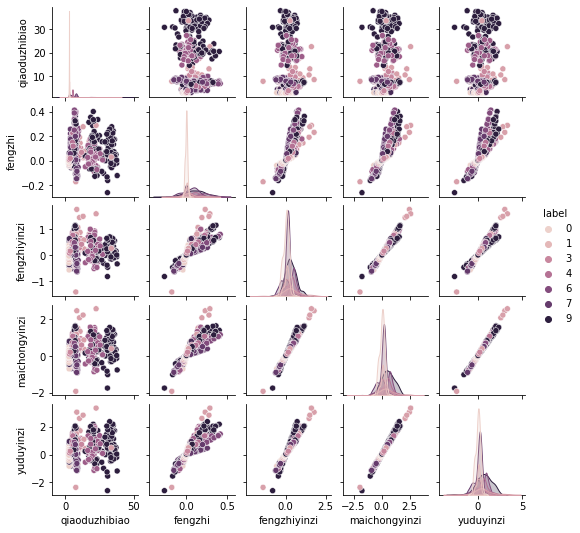

In [11]:
temp = pd.concat([x_train, y_train], axis=1)
sns.pairplot(data=temp, hue='label', vars=x_train.columns[-5:], height=1.5)

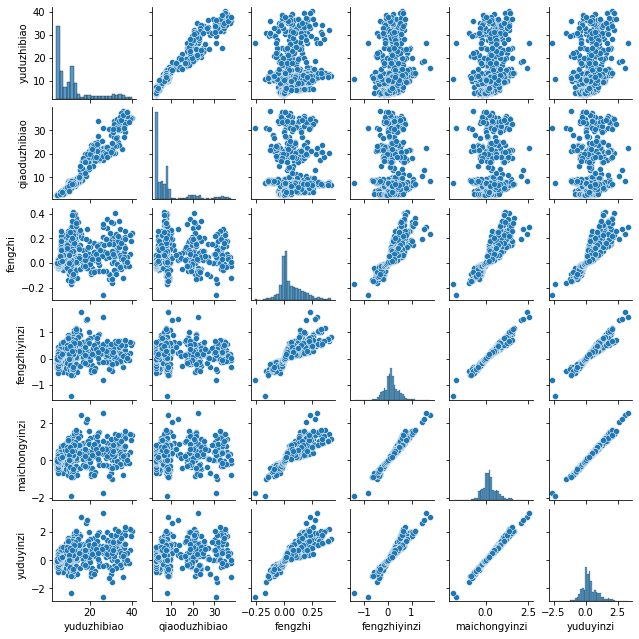

In [12]:
sns.pairplot(x_train, vars=x_train.columns[-6:], height=1.5)

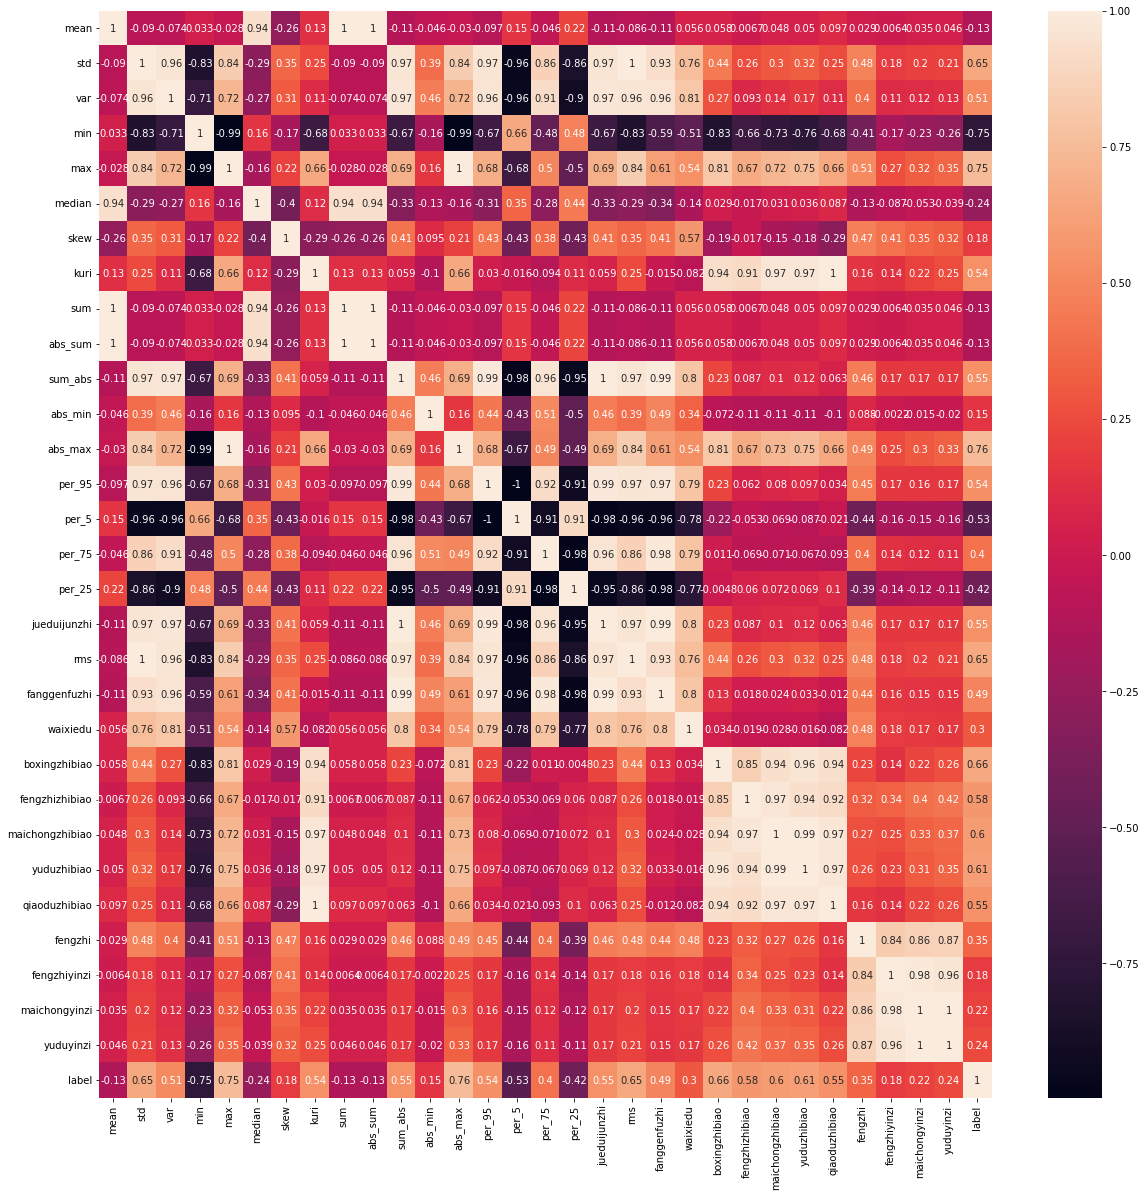

In [13]:
corrmat = temp.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corrmat, annot=True, )
plt.show()

In [14]:
x_tra, x_val, y_tra, y_val = train_test_split(x_train, y_train.values.reshape(len(y_train), ), test_size=0.2, random_state=2021,
                                             )  # stratify=y_train.values.reshape(len(y_train), )

In [15]:
# 原始数据提取的特征 lgb

lgb_model_ori = LGBMClassifier(random_state=2021)
lgb_model_ori.fit(x_tra, y_tra)

print('f1 score (Train): ', f1_score(y_tra, lgb_model_ori.predict(x_tra),average='macro'))
print('f1 score (val): ', f1_score(y_val, lgb_model_ori.predict(x_val), average='macro'))
print('acc score (Train): ', accuracy_score(y_tra, lgb_model_ori.predict(x_tra)))
print('acc score (val): ', accuracy_score(y_val, lgb_model_ori.predict(x_val)))

f1 score (Train):  1.0
f1 score (val):  0.9796262582994217
acc score (Train):  1.0
acc score (val):  0.9811320754716981


<AxesSubplot:xlabel='importance', ylabel='feature'>

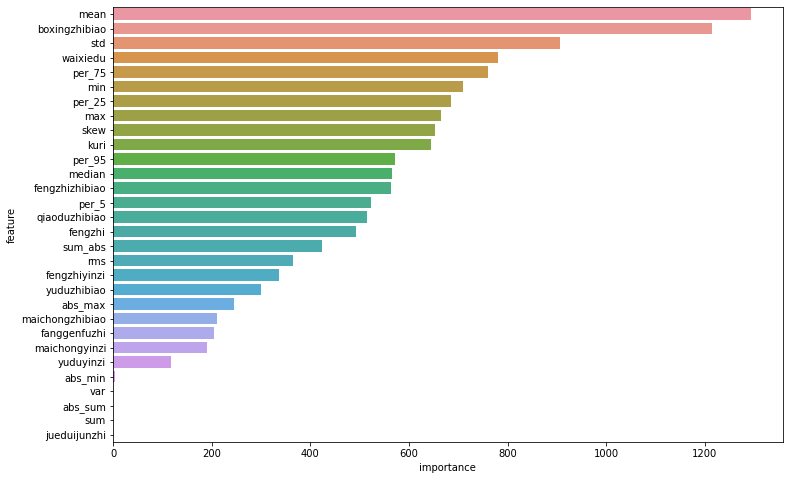

In [16]:
feature_imp = pd.DataFrame()
feature_imp['feature'] = lgb_model_ori.feature_name_
feature_imp['importance'] = lgb_model_ori.feature_importances_
feature_imp.sort_values('importance', ascending=False, inplace=True)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot()
sns.barplot(x='importance', y='feature', data=feature_imp, ax=ax)

#### 模态分解+样本熵

In [12]:
from PyEMD import EMD, EEMD,CEEMDAN

In [13]:
emd = EMD(extrema_detection="parabol", DTYPE=np.float16)
eemd = EEMD(trials=100, noise_width=0.2, ext_EMD=emd, parallel=True, processes=4, spline_kind='akima', max_imfs=6)

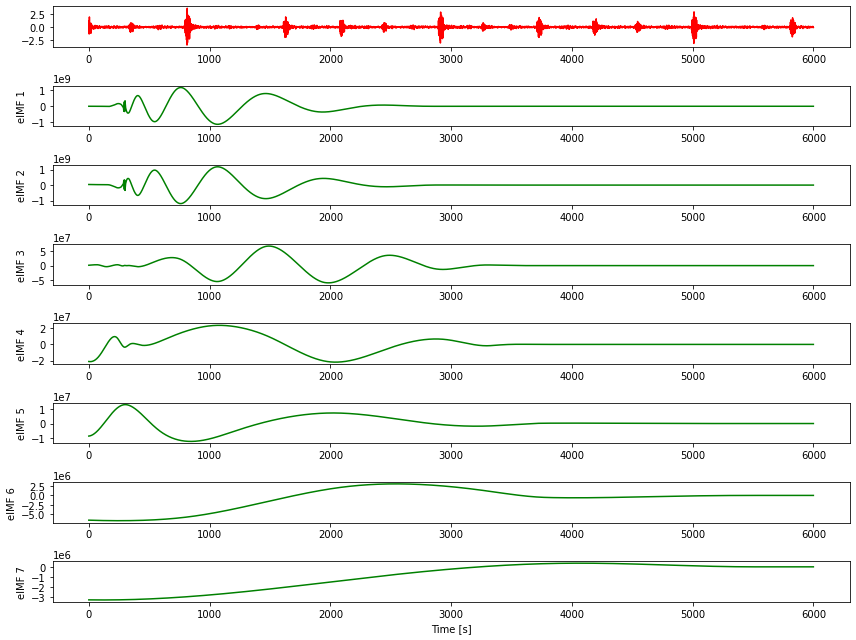

In [14]:
rs_df = {}

for label in range(10):
    temp = df_train[y_train['label'] == label]
    signal = temp.iloc[10]['1':].values
    IMFs = emd.emd(signal, max_imf=6)
    rs = []
    for i in range(IMFs.shape[0]):
        r = pearsonr(signal, IMFs[i])[0]
        rs.append(abs(r))
        
    rs_df[label] = rs

nIMFs = IMFs.shape[0]

plt.figure(figsize=(12,9))
plt.subplot(nIMFs+1, 1, 1)
plt.plot(signal, 'r')

for n in range(nIMFs):
    plt.subplot(nIMFs+1, 1, n+2)
    plt.plot(IMFs[n], 'g')
    plt.ylabel("eIMF %i" %(n+1))
    plt.locator_params(axis='y', nbins=5)

plt.xlabel("Time [s]")
plt.tight_layout()
# plt.savefig('eemd_example', dpi=120)
plt.show()

In [15]:
nIMFs

7

In [16]:
def get_emd_entrp_features(df):
    """将每个 IMF 分量作为独立的一段信号，分别计算它们的样本熵/排列熵"""
    Ens = []
    index = 1
    for idx in range(len(df)):
        signal = df.iloc[idx][index:].values
        eIMFs = eemd.eemd(signal, max_imf=6)
        nIMF = eIMFs.shape[0]
        print(nIMF)
        samE = []
        perE = []
        for i in range(nIMF):
            samE.append(sampen2(eIMFs[i].tolist(),mm=2, r=0.2, normalize=True)[-1][1])
#             samE.append(entropy.sample_entropy(eIMFs[i], sample_length=2+1, tolerance=0.2))
        for j in range(nIMF):
            perE.append(entropy.permutation_entropy(eIMFs[j],order=3, delay=1, normalize=True))
            
        En = samE + perE
        Ens.append(En)
    temp = pd.DataFrame(Ens, columns=['IMFSE%d'%d for d in range(1, nIMF+1)] + ['IMFPE%d'%d for d in range(1, nIMF+1)])
    return temp

In [ ]:
# x_train_emd = get_emd_entrp_features(df_train)
# x_test_emd = get_emd_entrp_features(df_test)
# x_train_emd.shape, x_test_emd.shape

#### FFT

In [17]:
# 提取频域实部
df_train_fft_real = pd.DataFrame(columns=df_train.columns[1:])
for i in range(len(df_train)):
    df_train_fft_real.loc[i,'1':'6000'] = fft(df_train.iloc[i][1:].values).real

df_test_fft_real = pd.DataFrame(columns=df_test.columns[1:])
for i in range(len(df_test)):
    df_test_fft_real.loc[i,'1':'6000'] = fft(df_test.iloc[i][1:].values).real

In [18]:
# 提取频域幅值 不归一化 不取一半（单边）
df_train_fft = pd.DataFrame(columns=df_train.columns[1:])
for i in range(len(df_train)):
    df_train_fft.loc[i,'1':'6000'] = np.abs(fft(df_train.iloc[i][1:].values)) 

df_test_fft = pd.DataFrame(columns=df_test.columns[1:])
for i in range(len(df_test)):
    df_test_fft.loc[i,'1':'6000'] = np.abs(fft(df_test.iloc[i][1:].values)) 

In [19]:
x_train_fft = get_features(df_train_fft, is_fft=True)
x_test_fft = get_features(df_test_fft, is_fft=True)

x_train_fft_real = get_features(df_train_fft_real, is_fft=True)
x_test_fft_real = get_features(df_test_fft_real, is_fft=True)

x_train_fft_real.shape

(792, 15)

In [20]:
df_train_fft.head(1)

,1,2,3,4,5,6,7,8,9,10,...,5991,5992,5993,5994,5995,5996,5997,5998,5999,6000
0,28.5894,1.07711,0.767205,0.462747,0.622432,0.838888,0.947208,0.716608,0.813071,0.705314,...,0.799572,0.705314,0.813071,0.716608,0.947208,0.838888,0.622432,0.462747,0.767205,1.07711


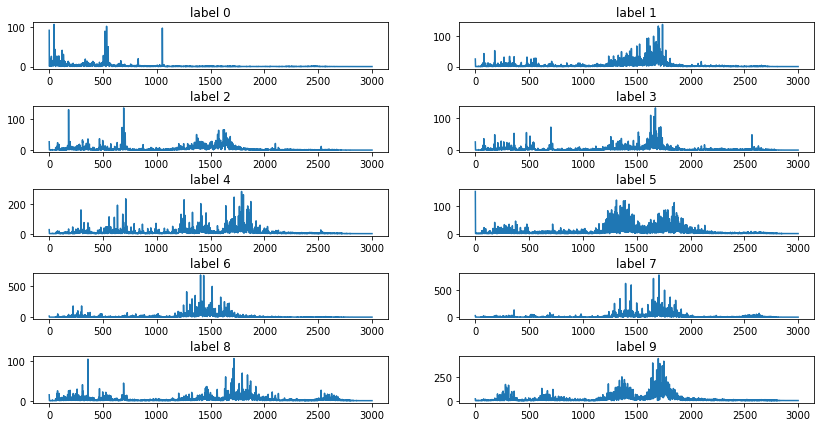

In [21]:
fig,ax = plt.subplots(5,2,figsize=(14, 7))
for i, axi in enumerate(ax.flat):
    temp = df_train_fft[y_train['label'] == i]
    N = int(df_train_fft.shape[1] / 2)
    axi.plot(temp.iloc[0]['1':].values[:N])
    axi.set_title('label %s' %i)
# plt.subplots_adjust()
fig.subplots_adjust(hspace=0.8)
# plt.savefig('label pic.png', dpi=400)
plt.show()

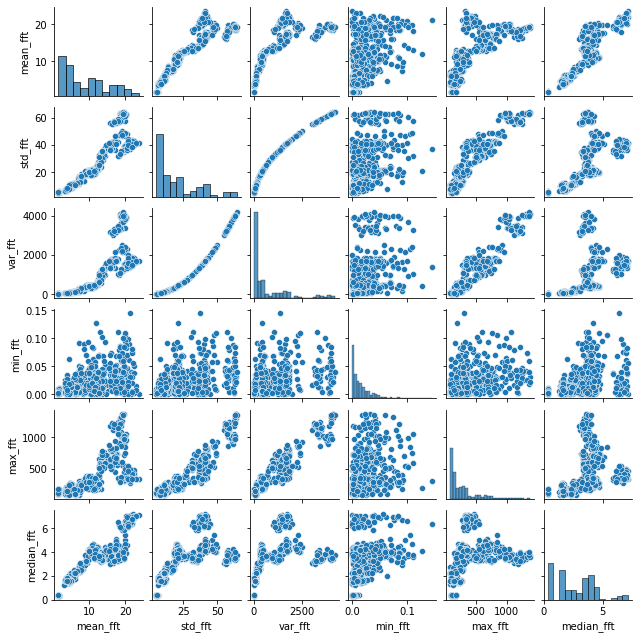

In [22]:
sns.pairplot(x_train_fft, vars=x_train_fft.columns[:6], height=1.5)

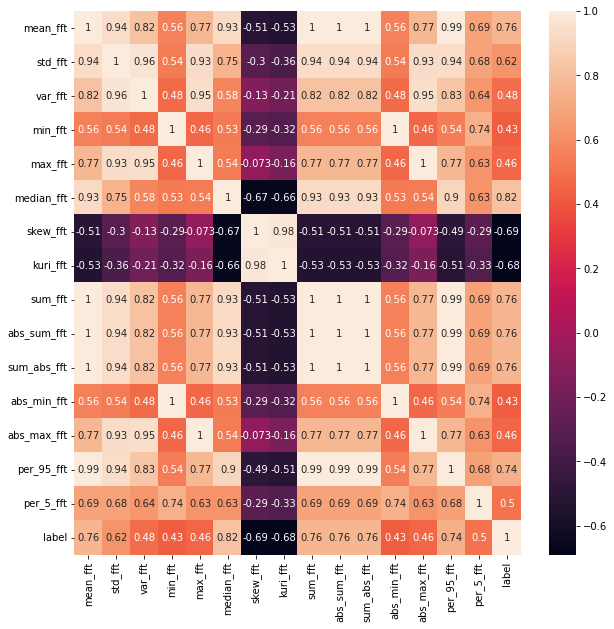

In [23]:
temp = pd.concat([x_train_fft, y_train], axis=1)
corrmat = temp.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corrmat, annot=True, )
plt.show()

In [24]:
x_tra_fft_real, x_val_fft_real, y_tra_fft_real, y_val_fft_real = train_test_split(x_train_fft_real, 
                                                                                  y_train.values.reshape(len(y_train), ), test_size=0.2)

# stratify=y_train.values.reshape(len(y_train), )
x_tra_fft, x_val_fft, y_tra_fft, y_val_fft = train_test_split(x_train_fft, y_train.values.reshape(len(y_train), ), test_size=0.2)

In [25]:
# LGB 在频域
lgb_model_freq = LGBMClassifier(random_state=2021)

lgb_model_freq.fit(x_tra_fft, y_tra_fft)
print('f1 score (Train): ', f1_score(y_tra_fft, lgb_model_freq.predict(x_tra_fft),average='macro'))
print('f1 score (val): ', f1_score(y_val_fft, lgb_model_freq.predict(x_val_fft), average='macro'))
print('acc score (Train): ', accuracy_score(y_tra_fft, lgb_model_freq.predict(x_tra_fft)))
print('acc score (val): ', accuracy_score(y_val_fft, lgb_model_freq.predict(x_val_fft)))

f1 score (Train):  1.0
f1 score (val):  0.9586438716867803
acc score (Train):  1.0
acc score (val):  0.9685534591194969


In [26]:
# LGB 在实部
lgb_model_real = LGBMClassifier(random_state=2021)

lgb_model_real.fit(x_tra_fft_real, y_tra_fft_real)
print('f1 score (Train): ', f1_score(y_tra_fft_real, lgb_model_real.predict(x_tra_fft_real),average='macro'))
print('f1 score (val): ', f1_score(y_val_fft_real, lgb_model_real.predict(x_val_fft_real), average='macro'))
print('acc score (Train): ', accuracy_score(y_tra_fft_real, lgb_model_real.predict(x_tra_fft_real)))
print('acc score (val): ', accuracy_score(y_val_fft_real, lgb_model_real.predict(x_val_fft_real)))

f1 score (Train):  1.0
f1 score (val):  0.8074790133936993
acc score (Train):  1.0
acc score (val):  0.8679245283018868


In [27]:
x_train_merge = pd.concat([x_train, x_train_fft], axis=1)
x_train_merge_real = pd.concat([x_train, x_train_fft_real], axis=1)

x_test_merge = pd.concat([x_test, x_test_fft], axis=1)
x_test_merge_real = pd.concat([x_test, x_test_fft_real], axis=1)

In [28]:
x_tra_merge, x_val_merge, y_tra_merge, y_val_merge = train_test_split(x_train_merge, y_train.values.reshape(len(y_train),), 
                                                                      test_size=0.2, random_state=2021)

# stratify=y_train.values.reshape(len(y_train), )
x_tra_merge_real, x_val_merge_real, y_tra_merge_real, y_val_merge_real = train_test_split(x_train_merge_real, y_train.values.reshape(len(y_train),), 
                                                                      test_size=0.2, random_state=2021)

In [29]:
# 原始特征结合频域 LGB
lgb_model_merge = LGBMClassifier(random_state=2021)
lgb_model_merge.fit(x_tra_merge, y_tra_merge)

print('f1 score (Train): ', f1_score(y_tra_merge, lgb_model_merge.predict(x_tra_merge),average='macro'))
print('f1 score (val): ', f1_score(y_val_merge, lgb_model_merge.predict(x_val_merge), average='macro'))
print('acc score (Train): ', accuracy_score(y_tra_merge, lgb_model_merge.predict(x_tra_merge)))
print('acc score (val): ', accuracy_score(y_val_merge, lgb_model_merge.predict(x_val_merge)))

f1 score (Train):  1.0
f1 score (val):  0.9873987450719085
acc score (Train):  1.0
acc score (val):  0.9874213836477987


In [30]:
# 原始特征结合实部 LGB
lgb_model_real = LGBMClassifier()
lgb_model_real.fit(x_tra_merge_real, y_tra_merge_real)

print('f1 score (Train): ', f1_score(y_tra_merge_real, lgb_model_real.predict(x_tra_merge_real),average='macro'))
print('f1 score (val): ', f1_score(y_val_merge_real, lgb_model_real.predict(x_val_merge_real), average='macro'))
print('acc score (Train): ', accuracy_score(y_tra_merge_real, lgb_model_real.predict(x_tra_merge_real)))
print('acc score (val): ', accuracy_score(y_val_merge_real, lgb_model_real.predict(x_val_merge_real)))

f1 score (Train):  1.0
f1 score (val):  0.9805848504319268
acc score (Train):  1.0
acc score (val):  0.9811320754716981


#### 小波包能量熵

In [31]:
def get_wp_entrp(df, n=3):

    features = []
    cols = []
    for i in range(len(df)):
        wp = pywt.WaveletPacket(df.iloc[i][1:].values, wavelet='db3', maxlevel=n, mode='symmetric')
        sample_EE = []
        for level in range(n,n+1): # n=n最后一层节点， n=1所有层节点
            tmp = []
            for node in [node.path for node in wp.get_level(level, 'freq')]:
                if i==0:
                    cols.append(node)
                data = np.array(wp[node].data)
                # 第i个样本第level层的第j个节点, level层有2**level个节点
                Eji = sum(pow(abs(data), 2))  # pow(np.linalg.norm(data,ord=None),2)
                tmp.append(Eji)
            tmp = np.array(tmp)
            Ej = sum(tmp)
            Pji = tmp / Ej
            Wji = -1 * Pji * np.log(Pji)
            sample_EE.extend(Wji.tolist())
        features.append(sample_EE)
    x = pd.DataFrame(features, columns=cols)
            
    return x

x_train_wpE = get_wp_entrp(df_train)
x_test_wpE = get_wp_entrp(df_test)

print(x_train_wpE.shape, x_test_wpE.shape)

(792, 8) (528, 8)


In [32]:
x_tra_wpE, x_val_wpE, y_tra_wpE, y_val_wpE = train_test_split(x_train_wpE, y_train.values.reshape(len(y_train), ), test_size=0.2,  random_state=1)

lgb_model_freq = LGBMClassifier(random_state=2021)
lgb_model_freq.fit(x_tra_wpE, y_tra_wpE)
print('f1 score (Train): ', f1_score(y_tra_wpE, lgb_model_freq.predict(x_tra_wpE),average='macro'))
print('f1 score (val): ', f1_score(y_val_wpE, lgb_model_freq.predict(x_val_wpE), average='macro'))
print('acc score (Train): ', accuracy_score(y_tra_wpE, lgb_model_freq.predict(x_tra_wpE)))
print('acc score (val): ', accuracy_score(y_val_wpE, lgb_model_freq.predict(x_val_wpE)))

f1 score (Train):  1.0
f1 score (val):  1.0
acc score (Train):  1.0
acc score (val):  1.0


In [33]:
def to_file(label, df_test, filename):
    """
    将预测的label组合成csv文件输出
    """
    result = pd.DataFrame()
    result['id'] = df_test['id']
    result['label'] = label
    result.to_csv(filename, index=False, encoding="utf-8")
    # rst = clf.predict(test)

test_pred = lgb_model_freq.predict(x_test_wpE)
to_file(test_pred, df_test, filename='wpee.csv')

#### 小波包能量特征提取

In [34]:
def wpd_plt(signal,n):
    #wpd分解
    wp = pywt.WaveletPacket(data=signal, wavelet='db1',mode='symmetric',maxlevel=n)
 
    #计算每一个节点的系数，存在map中，key为'aa'等，value为列表
    map = {}
    map[1] = signal
    for row in range(1,n+1):
        lev = []
        for i in [node.path for node in wp.get_level(row, 'freq')]:
            map[i] = wp[i].data
 
    #作图
    plt.figure(figsize=(15, 10))
    plt.subplot(n+1,1,1) #绘制第一个图
    plt.plot(map[1])
    for i in range(2,n+2):
        level_num = pow(2,i-1)  #从第二行图开始，计算上一行图的2的幂次方
        #获取每一层分解的node：比如第三层['aaa', 'aad', 'add', 'ada', 'dda', 'ddd', 'dad', 'daa']
        re = [node.path for node in wp.get_level(i-1, 'freq')]  
        for j in range(1,level_num+1):
            plt.subplot(n+1,level_num,level_num*(i-1)+j)
            plt.plot(map[re[j-1]]) #列表从0开始
            plt.title(re[j-1])

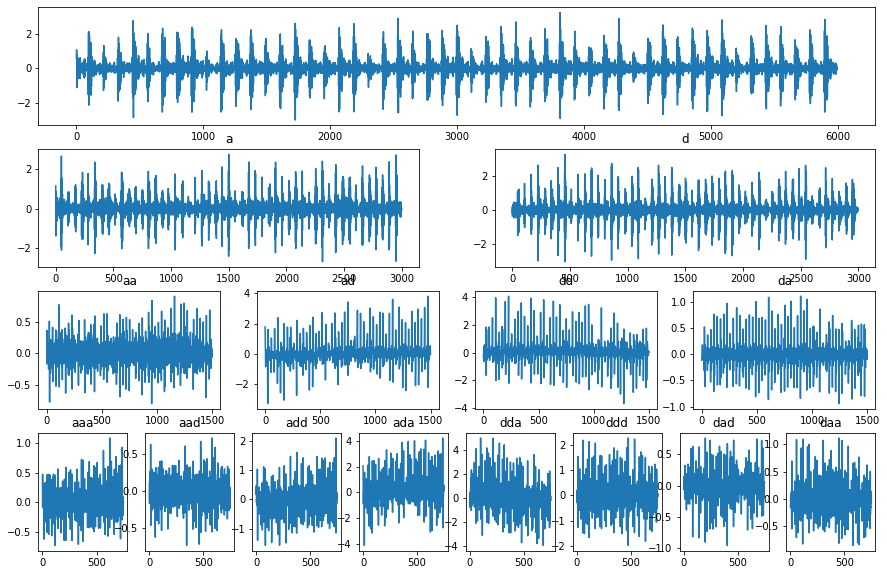

In [35]:
signal = df_train.iloc[0][1:].values
n = 3
wpd_plt(signal, n)

In [2]:
import numpy as np

np.linalg.norm(np.array([2,2,2]))

3.4641016151377544

In [36]:
def get_wp_features(df):
    x = pd.DataFrame()
    for i in range(len(df)):
        n = 3
        wp = pywt.WaveletPacket(df.iloc[i][1:].values, wavelet='db3', maxlevel=n, mode='symmetric')
        re = {}
        for level in range(n,n+1):
            for node in [node.path for node in wp.get_level(level, 'freq')]:
                re[node] = wp[node].data

        energy = pd.DataFrame()
        for k in re:
            energy[k] = [pow(np.linalg.norm(re[k],ord=None),2)]

        x = pd.concat([x, energy], axis=0)
        x.reset_index(inplace=True, drop=True)
    return x

In [37]:
x_train_wp = get_wp_features(df_train)
x_test_wp = get_wp_features(df_test)
x_train_wp.shape, x_test_wp.shape

((792, 8), (528, 8))

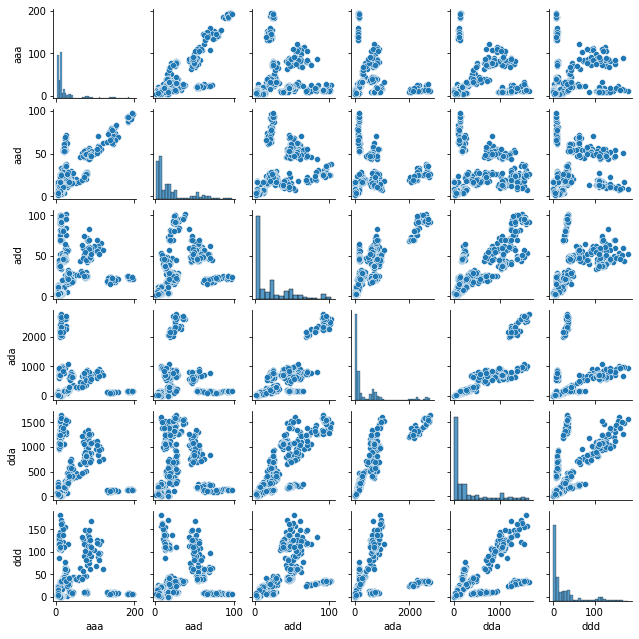

In [38]:
sns.pairplot(x_train_wp, height=1.5, vars=x_train_wp.columns[:6])

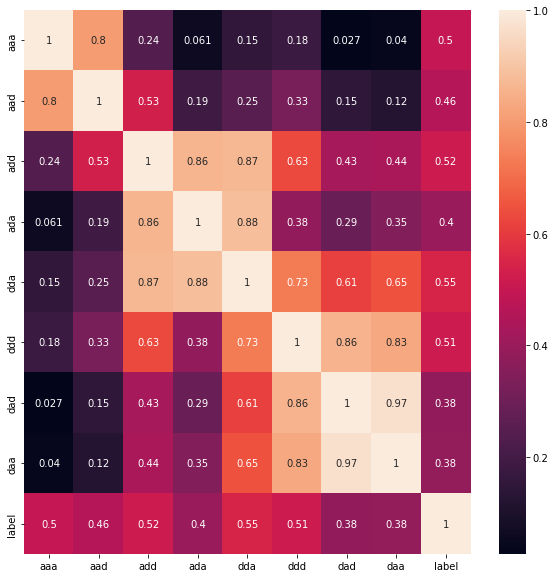

In [39]:
temp = pd.concat([x_train_wp, y_train], axis=1)
corrmat = temp.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corrmat, annot=True, )
plt.show()

In [40]:
x_tra_wp, x_val_wp, y_tra_wp, y_val_wp = train_test_split(x_train_wp, y_train.values.reshape(len(y_train), ),
                                                          test_size=0.2, random_state=1)  # stratify=y_train.values.reshape(len(y_train), )

# wp特征 lgb
lgb_wp = LGBMClassifier(random_state=2021)
lgb_wp.fit(x_tra_wp, y_tra_wp)
print('f1 score (Train): ', f1_score(y_tra_wp, lgb_wp.predict(x_tra_wp),average='macro'))
print('f1 score (val): ', f1_score(y_val_wp, lgb_wp.predict(x_val_wp), average='macro'))
print('acc score (Train): ', accuracy_score(y_tra_wp, lgb_wp.predict(x_tra_wp)))
print('acc score (val): ', accuracy_score(y_val_wp, lgb_wp.predict(x_val_wp)))

f1 score (Train):  1.0
f1 score (val):  1.0
acc score (Train):  1.0
acc score (val):  1.0


In [33]:
# 原始+小波
x_train_wp.reset_index(drop=True, inplace=True)
x_test_wp.reset_index(drop=True, inplace=True)

x_train_merge_wp = pd.concat([x_train, x_train_wp], axis=1, ignore_index=True)
x_test_merge_wp = pd.concat([x_test, x_test_wp], axis=1, ignore_index=True)

x_tra_merge_wp, x_val_merge_wp, y_tra_merge_wp, y_val_merge_wp = train_test_split(x_train_merge_wp, y_train.values.reshape(len(y_train), ),
                                                          test_size=0.2, random_state=2021)

In [34]:
# 原始+小波 lgb
lgb_merge_wp = LGBMClassifier(random_state=2021)
lgb_merge_wp.fit(x_tra_merge_wp, y_tra_merge_wp)
print('f1 score (Train): ', f1_score(y_tra_merge_wp, lgb_merge_wp.predict(x_tra_merge_wp),average='macro'))
print('f1 score (val): ', f1_score(y_val_merge_wp, lgb_merge_wp.predict(x_val_merge_wp), average='macro'))
print('acc score (Train): ', accuracy_score(y_tra_merge_wp, lgb_merge_wp.predict(x_tra_merge_wp)))
print('acc score (val): ', accuracy_score(y_val_merge_wp, lgb_merge_wp.predict(x_val_merge_wp)))

f1 score (Train):  1.0
f1 score (val):  0.9942437232088179
acc score (Train):  1.0
acc score (val):  0.9937106918238994


In [35]:
# 原始 + 傅里叶 + 小波
x_train_all = pd.concat([x_train, x_train_fft, x_train_wp], axis=1)
x_test_all = pd.concat([x_test, x_test_fft, x_test_wp], axis=1)
x_train_all.shape, x_test_all.shape

((792, 44), (528, 44))

In [36]:
x_tra_all, x_val_all, y_tra_all, y_val_all = train_test_split(x_train_all, y_train.values.reshape(len(y_train), ),
                                                          test_size=0.2, random_state=2021)

In [37]:
x_tra_all.shape, x_val_all.shape

((633, 44), (159, 44))

In [38]:
lgb_all = LGBMClassifier(random_state=2021)
lgb_all.fit(x_tra_all, y_tra_all)
print('f1 score (Train): ', f1_score(y_tra_all, lgb_all.predict(x_tra_all),average='macro'))
print('f1 score (val): ', f1_score(y_val_all, lgb_all.predict(x_val_all), average='macro'))
print('acc score (Train): ', accuracy_score(y_tra_all, lgb_all.predict(x_tra_all)))
print('acc score (val): ', accuracy_score(y_val_all, lgb_all.predict(x_val_all)))

f1 score (Train):  1.0
f1 score (val):  1.0
acc score (Train):  1.0
acc score (val):  1.0


<AxesSubplot:xlabel='importance', ylabel='feature'>

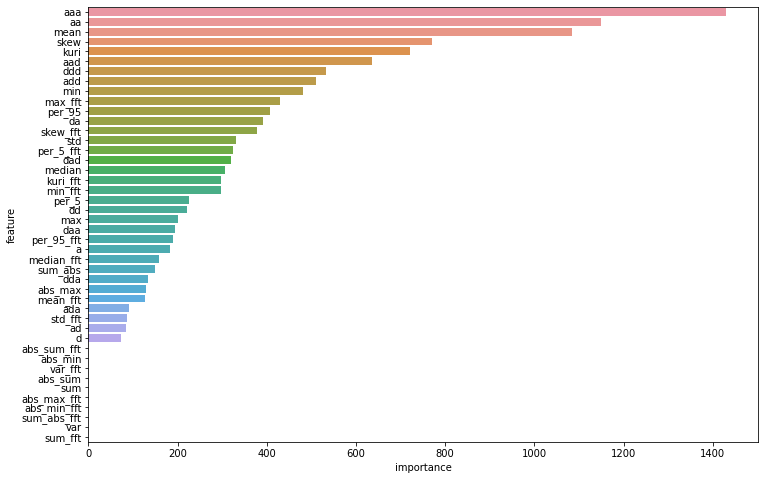

In [41]:
feature_imp = pd.DataFrame()
feature_imp['feature'] = lgb_all.feature_name_
feature_imp['importance'] = lgb_all.feature_importances_
feature_imp.sort_values('importance', ascending=False, inplace=True)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot()
sns.barplot(x='importance', y='feature', data=feature_imp, ax=ax)

In [42]:
features = feature_imp[feature_imp.importance > 200]['feature'].values.tolist()
features

['aaa',
 'aa',
 'mean',
 'skew',
 'kuri',
 'aad',
 'ddd',
 'add',
 'min',
 'max_fft',
 'per_95',
 'da',
 'skew_fft',
 'std',
 'per_5_fft',
 'dad',
 'median',
 'kuri_fft',
 'min_fft',
 'per_5',
 'dd']

In [43]:
lgb_all = LGBMClassifier(random_state=2021, n_estimators=1000)
lgb_all.fit(x_tra_all[features], y_tra_all)
print('f1 score (Train): ', f1_score(y_tra_all, lgb_all.predict(x_tra_all[features]),average='macro'))
print('f1 score (val): ', f1_score(y_val_all, lgb_all.predict(x_val_all[features]), average='macro'))
print('acc score (Train): ', accuracy_score(y_tra_all, lgb_all.predict(x_tra_all[features])))
print('acc score (val): ', accuracy_score(y_val_all, lgb_all.predict(x_val_all[features])))

f1 score (Train):  1.0
f1 score (val):  1.0
acc score (Train):  1.0
acc score (val):  1.0


In [ ]:
params = {
            'num_leaves': 40,
            'min_data_in_leaf': 20,
            'min_child_samples': 20,
            'objective': 'multiclass',
            'num_class':10,
            'metric': 'multi_logloss',

            'max_depth': 6,
            'learning_rate': 0.02,
            "boosting": "gbdt",
            "feature_fraction": 0.8,
            "bagging_freq": 1,
            "bagging_fraction": 0.9,
            "bagging_seed": 23,
#             "metric": 'rmse',
            "lambda_l1": 0.1,
            "nthread": 4,
            'verbose': -1
        }

oof_lgb = np.zeros(len(x_val_all))
predictions_lgb = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

trn_data = lgb.Dataset(x_tra_all[features], label=y_tra_all)
val_data = lgb.Dataset(x_val_all[features], label=y_val_all)

num_round = 20000
clf = lgb.train(params, trn_data, num_round, valid_sets=[trn_data, val_data],
                    verbose_eval=100, early_stopping_rounds=100)
aa = clf.predict(x_val_all[features], num_iteration=clf.best_iteration)
oof_lgb = list((map(lambda x:np.argmax(x),aa)))

fold_importance_df = pd.DataFrame()
fold_importance_df["feature"] = features
fold_importance_df["importance"] = clf.feature_importance()
feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

t = clf.predict(x_test_all[features], num_iteration=clf.best_iteration)
predictions_lgb = list((map(lambda x:np.argmax(x),t)))

print(feature_importance_df)
# plot_feature_importance(feature_importance_df)



In [ ]:

selector = SelectFromModel(estimator=LGBMClassifier()).fit(x_tra_all, y_tra_all)
x_tra_all_selected = selector.transform(x_tra_all)
x_val_all_selected = selector.transform(x_val_all)
x_test_all_selected = selector.transform(x_test_all)
x_tra_all_selected.shape

lgb_all = LGBMClassifier(random_state=2021)
lgb_all.fit(x_tra_all_selected, y_tra_all)
print('f1 score (Train): ', f1_score(y_tra_all, lgb_all.predict(x_tra_all_selected),average='macro'))
print('f1 score (val): ', f1_score(y_val_all, lgb_all.predict(x_val_all_selected), average='macro'))
print('acc score (Train): ', accuracy_score(y_tra_all, lgb_all.predict(x_tra_all_selected)))
print('acc score (val): ', accuracy_score(y_val_all, lgb_all.predict(x_val_all_selected)))

In [45]:
pca = PCA()
x_tra_pca = pca.fit_transform(x_tra_all)
x_val_pca = pca.transform(x_val_all)
x_test_pca = pca.transform(x_test_all)

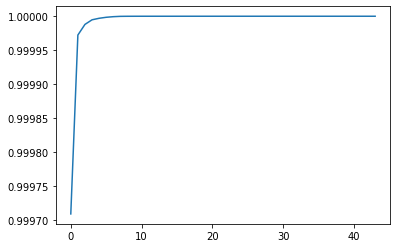

In [46]:
plt.plot(range(44), np.cumsum(pca.explained_variance_ratio_))
plt.show()

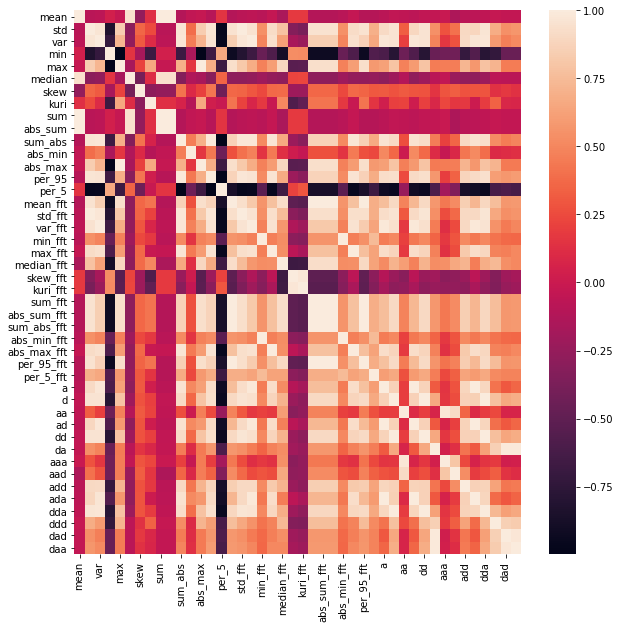

In [52]:
plt.figure(figsize=(10,10))
corr_all = x_train_all.corr()
sns.heatmap(corr_all,annot=False)
plt.show()

In [58]:
train_f1 = []
val_f1 = []
for i in range(1,45):
    pca = PCA(n_components=i)
    x_tra_pca = pca.fit_transform(x_tra_all)
    x_val_pca = pca.transform(x_val_all)
    x_test_pca = pca.transform(x_test_all)

    lgb_pca = LGBMClassifier(random_state=2021)
    lgb_pca.fit(x_tra_pca, y_tra_all)
    train_f1.append(f1_score(y_tra_all, lgb_pca.predict(x_tra_pca),average='macro'))
    val_f1.append(f1_score(y_val_all, lgb_pca.predict(x_val_pca), average='macro'))

D:\MyAnaconda\lib\site-packages\lightgbm\basic.py:306: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  warnings.warn("Usage of np.ndarray subset (sliced data) is not recommended "
D:\MyAnaconda\lib\site-packages\lightgbm\basic.py:306: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  warnings.warn("Usage of np.ndarray subset (sliced data) is not recommended "


In [61]:
np.argmax(val_f1)

8

In [63]:
pca = PCA(n_components=9)
x_tra_pca = pca.fit_transform(x_tra_all)
x_val_pca = pca.transform(x_val_all)
x_test_pca = pca.transform(x_test_all)

lgb_pca = LGBMClassifier(random_state=2021)
lgb_pca.fit(x_tra_pca, y_tra_all)
print(f1_score(y_tra_all, lgb_pca.predict(x_tra_pca),average='macro'))
print(f1_score(y_val_all, lgb_pca.predict(x_val_pca), average='macro'))

1.0
1.0


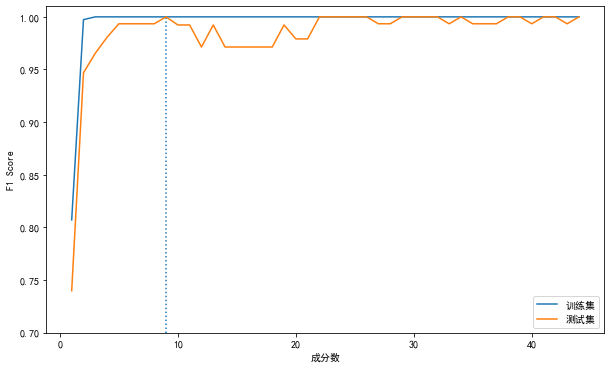

In [76]:
from matplotlib.pylab import mpl

mpl.rcParams['font.sans-serif'] = ['SimHei']  
mpl.rcParams['axes.unicode_minus']=False    

plt.figure(figsize=(10,6))
plt.plot(range(1, 45), train_f1, label='训练集')
plt.plot(range(1, 45), val_f1, label='测试集')
plt.vlines(x=9, ymin=0.7, ymax=1., linestyles='dotted')
plt.ylim(0.7, 1.01)
plt.xlabel('成分数')
plt.ylabel('F1 Score')
plt.legend(loc='lower right')
plt.show()

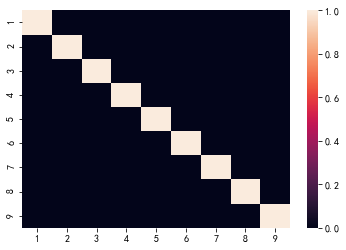

In [75]:
corr = np.corrcoef(x_tra_pca, rowvar=False)
sns.heatmap(corr, xticklabels=list(range(1,10)),yticklabels=list(range(1,10)))
plt.show()

In [17]:
import os

In [21]:
import sys

In [22]:
sys.version

'3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]'

In [24]:
import pandas_datareader.data as web

In [25]:
end = '2015-01-01'
start = '2007-01-01'
get_px = lambda x: web.DataReader(x, 'yahoo', start=start, end=end)['Adj Close']

symbols = ['SPY','TLT','MSFT']
# raw adjusted close prices
data = pd.DataFrame({sym:get_px(sym) for sym in symbols})

# log returns
lrets = np.log(data/data.shift(1)).dropna()

ReadTimeout: HTTPSConnectionPool(host='finance.yahoo.com', port=443): Read timed out. (read timeout=30)

### 数据特征切分Conv1D
- https://github.com/xiaoshuangyoyo/Bearing-fault-detection

- 1 对时间序列进行数据增强。训练集数量只有792条数据，数据量较小，使用CNN进行分类容易造成过拟合。因此可以将周期状态的6000维特征进行分割，切分成多段维度较小且相同的特征（经过实验可知，维度为3000，分割间隔为500）。对于每一条训练数据来说，可以数据增强为对应的七条训练数据。

- 2 将CNN用于一维时间信号的特征提取与识别。

- 3 采用投票法对分类结果进行故障分类。训练完毕的CNN分类器时会得到相应的七个标签，将这七个标签进行投票，得到概率最大的类别。

In [ ]:
# 切分特征
def train_y(y):
    """标签onehot"""
    y_one = np.zeros(10)
    y_one[y]=1
    return y_one
    
def data_processing_train():
    csv_file = pd.read_csv(train_path) # DataFram:792x6002
    dataset = np.array(csv_file)

    data_pre = dataset[:,1:6001] # float64 mnist:float32
    label_pre = dataset[:,6001]  # float64 mnist:float64
    data_pre=data_pre.astype(np.float32)
    label_pre=label_pre.astype(np.float64)
    
    data=[]
    label=[]
    for i in range(data_pre.shape[0]):
        for j in range(7):
            data.append(data_pre[i][j*500:j*500+3000])
            label.append(label_pre[i])
    
    data=np.array(data)
    label=np.array(label)
    
    label=label.astype(np.uint8)
    label_transform=np.array([train_y(label[i]) for i in range(len(label))])

    index=[i for i in range(len(data))]
    np.random.shuffle(index)
    trX=data[index[:]]
    trY=label_transform[index[:]]
    teX=data[index[:]]
    teY=label_transform[index[:]]        
            
    return trX,trY,teX,teY

def data_processing_test():
    csv_file=pd.read_csv(test_path) # DataFram:528x6001
    dataset=np.array(csv_file)

    data_pre=dataset[:,1:6001] # float64 mnist:float32
    data_pre=data_pre.astype(np.float32)
    
    test_data=[]
    for i in range(data_pre.shape[0]):
        for j in range(7):
            test_data.append(data_pre[i][j*500:j*500+3000])
    
    # do not shuffle
    test_data=np.array(test_data)
    return test_data
            

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
 
    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
 
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [ ]:
trX,trY,teX,teY = data_processing_train()
test_data = data_processing_test()

trX.shape, trY.shape

In [ ]:
from tensorflow.keras import backend as K

if K.image_data_format()=='channel_first':
    trX=trX.reshape(trX.shape[0],1,3000)
    teX=teX.reshape(teX.shape[0],1,3000)
    test_data=test_data.reshape(test_data.shape[0],1,3000)
    input_shape=(1,3000)
else:
    trX=trX.reshape(trX.shape[0],3000,1)
    teX=teX.reshape(teX.shape[0],3000,1)
    test_data=test_data.reshape(test_data.shape[0],3000,1)
    input_shape=(3000,1)

batch_size = 128
num_classes = 10
epochs = 50

from tensorflow.keras.layers import GlobalAveragePooling1D

model = Sequential()
model.add(Conv1D(16, kernel_size=3, strides=1, activation='relu', input_shape=input_shape))
model.add(Conv1D(16, kernel_size=3, strides=1, activation='relu'))
model.add(Conv1D(16, kernel_size=3, strides=1, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(32, kernel_size=3, strides=1, activation='relu', input_shape=input_shape))
model.add(Conv1D(32, kernel_size=3, strides=1, activation='relu'))
model.add(Conv1D(32, kernel_size=3, strides=1, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, kernel_size=3, strides=1, activation='relu', input_shape=input_shape))
model.add(Conv1D(64, kernel_size=3, strides=1, activation='relu'))
model.add(Conv1D(64, kernel_size=3, strides=1, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax', activity_regularizer=regularizers.l2(0.0002)))

sgd = SGD(lr=0.001, decay=1e-5)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy', f1])
model.summary()  # too big
model.fit(trX,trY,batch_size=batch_size,epochs=epochs,validation_data=(teX,teY),verbose=1)


In [ ]:
model.fit(trX,trY,batch_size=batch_size,epochs=epochs,validation_data=(teX,teY),verbose=1)

test_label=model.predict_classes(test_data)
label_process=test_label.reshape(528,7)
label=[]
for i in range(528):
    label.append([i+1,label_process[i][np.argmax(list(label_process[i]).count(x) for x in set(label_process[i]))]])

import csv
with open('test_label14.csv','w',newline='') as csvfile:
    writer=csv.writer(csvfile)
    writer.writerow(['id','label'])
    for row in label:
        writer.writerow(row)

### Conv1D
- https://github.com/xiaosongshine/bearing_detection_by_conv1d

In [26]:
batch_size = 32
long = 792
lens = 640

def convert2onehot(index, classes):
    hot = np.zeros((classes,))
    hot[int(index)] = 1
    return (hot)

# 生产器
def xs_gen(path=train_path, batch_size=batch_size, train=True, lens=lens):
    img_list = pd.read_csv(path)
    if train:
        img_list = np.array(img_list)[:lens]
#         print("Found %s train items."%len(img_list))
#         print("list 1 is",img_list[0,-1])
        steps = math.ceil(len(img_list) / batch_size)
    else:
        img_list = np.array(img_list)[lens:]
#         print("Found %s train items."%len(img_list))
#         print("list 1 is",img_list[0,-1])
        steps = math.ceil(len(img_list) / batch_size)
        
    while True:
        for i in range(steps):
            batch_list = img_list[i*batch_size : (i+1) * batch_size]
            np.random.shuffle(batch_list)
            batch_x = np.array([file for file in batch_list[:, 1:-1]]) # without "id" & "label"
            batch_y = np.array([convert2onehot(label, 10) for label in batch_list[:,-1]])
            yield batch_x, batch_y
            
def ts_gen(path=test_path, batch_size=batch_size):
    
    img_list = pd.read_csv(path)
    img_list = np.array(img_list)
#     print("Found %s train items."%len(img_list))
#     print("list 1 is",img_list[0,-1])
    steps = math.ceil(len(img_list) / batch_size)
    
    while True:
        for i in range(steps):
            batch_list = img_list[i*batch_size : (i+1) * batch_size]
#             np.random.shuffle(batch_list)
            batch_x = np.array([file for file in batch_list[:, 1:]]) # without "id" 
#             batch_y = np.array([convert2onehot(label, 10) for label in batch_list[:,-1]])
            yield batch_x

In [28]:
show_iter = xs_gen()
for x,y in show_iter:  # data change every call
    x1 = x[0]
    y1 = y[0]
    print(y1)
    print(x1)
    print(y.shape)
    print(x.shape)
    break
  


[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[-0.31707337  0.15057737  1.27771473 ...  0.05668986 -0.21798794
  0.10704475]
(32, 10)
(32, 6000)


In [29]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Reshape
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '0' 
tf.random.set_seed(42)
np.random.seed(42)

In [30]:
time_periods = 6000
def build_model(input_shape=(time_periods,), num_classes=10):
    model = Sequential()
    model.add(Reshape((time_periods, 1), input_shape=input_shape))
    model.add(Conv1D(16, kernel_size=8, strides=2, activation='relu', input_shape=(time_periods, 1)))
    model.add(Conv1D(16, 8, strides=2, activation='relu',padding="same"))
    model.add(MaxPooling1D(2))

    model.add(Conv1D(64, 4, strides=2, activation='relu',padding="same"))
    model.add(Conv1D(64, 4, strides=2, activation='relu',padding="same"))
    model.add(MaxPooling1D(2))
    
    model.add(Conv1D(256, 4, strides=2, activation='relu',padding="same"))
    model.add(Conv1D(256, 4, strides=2, activation='relu',padding="same"))
    model.add(MaxPooling1D(2))
    
    model.add(Conv1D(512, 2, strides=1, activation='relu',padding="same"))
    model.add(Conv1D(512, 2, strides=1, activation='relu',padding="same"))
    model.add(MaxPooling1D(2))
    """model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu'))"""
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    return model


In [31]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 6000, 1)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2997, 16)          144       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1499, 16)          2064      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 749, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 375, 64)           4160      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 188, 64)           16448     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 94, 64)            0

In [ ]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
#         val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_predict = np.argmax(np.asarray(self.model.predict(self.validation_data[0])), axis=1)
#         val_targ = self.validation_data[1]
        val_targ = np.argmax(self.validation_data[1], axis=1)
        _val_f1 = f1_score(val_targ, val_predict, average='macro')
#         _val_recall = recall_score(val_targ, val_predict)
#         _val_precision = precision_score(val_targ, val_predict)
        self.val_f1s.append(_val_f1)
#         self.val_recalls.append(_val_recall)
#         self.val_precisions.append(_val_precision)
#         print('— val_f1: %f — val_precision: %f — val_recall %f' %(_val_f1, _val_precision, _val_recall))
        print(' — val_f1:' ,_val_f1)
        return

metrics = Metrics()

Instructions for updating:
Please use Model.predict, which supports generators.
17/17 [==============================] - 0s 12ms/step
(528, 10)
(528,)


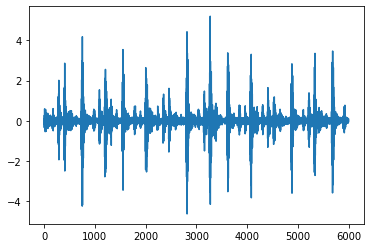

In [34]:
Train = True
Train = False
# if __name__ == "__main__":
if Train == True:
    train_gen = xs_gen()
    val_gen = xs_gen(train=False)
    
    ckpt = tf.keras.callbacks.ModelCheckpoint(filepath='./checkpoint_models/best_model.{epoch:02d}-{val_loss:.4f}.h5',
                                             monitor='val_loss', save_best_only=True, verbose=1)
    model = build_model()
    opt = tf.keras.optimizers.Adam(0.0002)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    model.fit_generator(train_gen, steps_per_epoch=lens//batch_size, epochs=100, initial_epoch=0, validation_data=val_gen,
                       validation_steps=(long - lens)//batch_size, callbacks=[ckpt])
    model.save("./checkpoint_models/finishModel.h5")
else:
    test_iter = ts_gen()
    model = load_model("./checkpoint_models/best_model.87-0.0018.h5")
    pres = model.predict_generator(generator=test_iter,steps=math.ceil(528/batch_size),verbose=1)
    print(pres.shape)
    ohpres = np.argmax(pres,axis=1)
    print(ohpres.shape)
    #img_list = pd.read_csv(TEST_MANIFEST_DIR)
    df = pd.DataFrame()
    df["id"] = np.arange(1,len(ohpres)+1)
    df["label"] = ohpres
    df.to_csv("submit_cnn.csv",index=None)
#     test_iter = ts_gen()
#     for x in test_iter:
#         x1 = x[0]
#         break
#     plt.plot(x1)
#     plt.show()